In [1]:
# Install lsdb and S3 to access PS1 data. And matplotlib for plotting!
%pip install --quiet lsdb s3fs matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import dask.distributed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lsdb import read_hipscat, from_dataframe

In [3]:
# Define paths to PS1 DR2 catalogs
PS1_PATH = "s3://stpubdata/panstarrs/ps1/public/hipscat"
PS1_OBJECT = f"{PS1_PATH}/otmo"
PS1_DETECTION = f"{PS1_PATH}/detection"

In [4]:
# Get SNAD catalog as an example of a small catalog in a pandas dataframe
# https://snad.space/catalog/
snad_df = pd.read_csv(
    "https://snad.space/catalog/snad_catalog.csv",
    dtype_backend='pyarrow',
).rename(columns={"R.A.": "ra", "Dec.": "dec"}).dropna()
display(snad_df)

# Convert to LSDB's Catalog object
snad_catalog = from_dataframe(
    snad_df,
    # Optimize partition size
    drop_empty_siblings=True,
    # Keep partitions small
    lowest_order=3,
)
display(snad_catalog)

,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments
0,SNAD101,247.45543,24.77282,633207400004730,2018-04-08 09:45:49,21.11,0.27,0.36,20.84,0.06,AT 2018lwh,PSN,ZTF18abqkqdm
1,SNAD102,245.05375,28.3822,633216300024691,2018-03-21 11:08:19,21.18,0.28,0.39,20.26,0.07,AT 2018lwi,PSN,ZTF18abdgwos
3,SNAD104,218.9162,46.38441,758205400019523,2018-06-24 07:23:27,20.1,0.14,0.16,20.89,0.1,AT 2018lwk,PSN,ZTF18aawqbuc
7,SNAD108,257.84004,48.21127,762209400037712,2018-04-16 10:34:47,21.23,0.28,0.38,20.99,0.06,AT 2018lwo,PSN,ZTF18abauopo
10,SNAD111,263.42634,52.62203,796201100002136,2018-06-21 07:59:02,21.32,0.28,0.39,21.72,0.15,AT 2018lwr,PSN,ZTF18abdldos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,SNAD251,206.83488,46.85701,757206100012904,2018-05-12 05:54:12,20.81,0.27,0.36,20.55*,0.02,AT 2018moe,PSN,ZTF18aautehk
152,SNAD254,245.16939,29.81557,633216100000357,2018-05-24 08:39:53,20.49,0.2,0.25,19.68,0.04,AT 2018moh,PSN,ZTF18aazziao
154,SNAD256,263.56442,25.83772,635106200001974,2018-03-26 12:07:33,20.5,0.18,0.21,21.55*,0.03,AT 2018moj,AGN,ZTF18aashxde
155,SNAD257,275.96866,27.24837,637112100033906,2018-07-09 09:11:44,21.36,0.28,0.37,20.56,0.04,AT 2018mok,PSN,ZTF18abhxidx


,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments,Norder,Dir,Npix
npartitions=54,,,,,,,,,,,,,,,,
281193501733945344,string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow]
1567252670324932608,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9205357638345293824,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [5]:
# Load PS1 catalogs metadata
ps1_object = read_hipscat(
    PS1_OBJECT,
    # For anonymous S3 access
    storage_options={'anon': True},
    columns=[
        "objID",  # PS1 ID
        "raMean", "decMean",  # coordinates to use for cross-matching
        "nStackDetections",  # some other data to use
    ],
)
display(ps1_object)

ps1_detection = read_hipscat(
    PS1_DETECTION,
    # For anonymous S3 access
    storage_options={'anon': True},
    columns=[
        "objID",  # PS1 object ID
        "detectID",  # PS1 detection ID
        # not really going to use it, but we can alternatively directly cross-match with detection table
        "ra", "dec",
        # light-curve stuff
        "obsTime", "filterID", "psfFlux", "psfFluxErr",
    ],
)
display(ps1_detection)

/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


,objID,raMean,decMean,nStackDetections
npartitions=27161,,,,
0,int64[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow]
1125899906842624,...,...,...,...
...,...,...,...,...
13834776580305453056,...,...,...,...
18446744073709551615,...,...,...,...


/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


,objID,detectID,ra,dec,obsTime,filterID,psfFlux,psfFluxErr
npartitions=83004,,,,,,,,
0,int64[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],double[pyarrow],double[pyarrow]
281474976710656,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
13834776580305453056,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...


In [6]:
# Planning cross-matching with objects, no work happens here
snad_ps1 = ps1_object.crossmatch(
    snad_catalog,
    radius_arcsec=1.0,
    suffixes=["", ""],
)

# Join with detections to get light-curves
snad_ps1_lc = snad_ps1.join_nested(
    ps1_detection,
    left_on="objID",
    right_on="objID",
    # light-curve will live in "lc" column
    nested_column_name="lc",
    output_catalog_name="snad_ps1_lc",
)

display(snad_ps1_lc)

/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/crossmatch_catalog_data.py:108: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(
/ocean/projects/phy210048p/malanche/lsdb-tests/cenv/lib/python3.11/site-packages/lsdb/dask/join_catalog_data.py:334: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,objID,raMean,decMean,nStackDetections,Name,ra,dec,OID,Discovery date (UT),mag,er_down,er_up,ref,er_ref,TNS,Type,Comments,Norder,Dir,Npix,_dist_arcsec,lc
npartitions=240,,,,,,,,,,,,,,,,,,,,,,
281193501733945344,int64[pyarrow],double[pyarrow],double[pyarrow],int16[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],uint8[pyarrow],uint64[pyarrow],uint64[pyarrow],double[pyarrow],"nested<detectID: [int64], ra: [double], dec: [..."
1568941520185196544,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9214927787553456128,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [7]:
%%time

# Create Dask client and "compute" light curves into a new nested data frame
# See noested-pandas docs for details
# https://nested-pandas.readthedocs.io/en/latest/

# You may need to change Dask cluster parameters, refer to Dask docs and adjust accrodingly to your hardware
# https://docs.dask.org/en/stable/deploying.html
# https://docs.dask.org/en/stable/deploying-python.html?highlight=LocalCluster#distributed.deploy.local.LocalCluster
with dask.distributed.Client() as client:
    display(client)
    ndf = snad_ps1_lc.compute()
    
display(ndf)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 247.07 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40553,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 247.07 GiB
Comm: tcp://127.0.0.1:35729,Total threads: 8
Dashboard: http://127.0.0.1:41745/status,Memory: 15.44 GiB
Nanny: tcp://127.0.0.1:43081,


,objID,raMean,decMean,nStackDetections,Name,ra,dec,OID,Discovery date (UT),mag,...,ref,er_ref,TNS,Type,Comments,Norder,Dir,Npix,_dist_arcsec,lc
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
281208404226080768,151140436186487948,43.618644,35.956121,10,SNAD258,43.61864,35.95618,653113400006264,2018-08-06 11:56:08,19.93,...,20.67*,0.02,AT 2018mol,PSN,ZTF18abtslir,7,0,3996,0.211484,detectID ra dec ...
1569109826691137536,161951715008458066,171.500832,44.964503,10,SNAD242,171.50084,44.9646,753101100007466,2018-06-03 04:41:06,20.97,...,20.03,0.06,AT 2018mds,PSN,ZTF18aaxqort,4,0,348,0.34803,detectID ra dec ...
1569109849621397504,161951715009348443,171.500674,44.964696,0,SNAD242,171.50084,44.9646,753101100007466,2018-06-03 04:41:06,20.97,...,20.03,0.06,AT 2018mds,PSN,ZTF18aaxqort,4,0,348,0.545609,detectID ra dec ...
1571691754028007424,165051732389348889,173.238928,47.548471,5,SNAD195,173.23891,47.54846,754108100010282,2019-05-14 05:00:23,20.62,...,20.84,0.04,AT 2019aapu,PSN,ZTF19aavkyng,4,0,348,0.058477,detectID ra dec ...
1784604555556683776,146131139194665999,113.919363,31.779575,0,SNAD243,113.9192,31.77959,662105400007673,2018-03-30 05:34:18,20.81,...,19.8,0.07,AT 2018mdt,PSN,ZTF18aceqval,7,20000,25360,0.501512,detectID ra dec ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9162679131643576320,136602659686272754,265.968642,23.835102,5,SNAD206,265.96869,23.83512,635101200003331,2019-06-01 10:34:06,20.78,...,20.47,0.05,AT 2019aaqf,PSN,ZTF19aawxogc,7,130000,130209,0.16953,detectID ra dec ...
9171175790732115968,140692759687248560,275.9687,27.248313,5,SNAD257,275.96866,27.24837,637112100033906,2018-07-09 09:11:44,21.36,...,20.56,0.04,AT 2018mok,PSN,ZTF18abhxidx,7,130000,130330,0.242748,detectID ra dec ...
9187971876939366400,139002635644905861,263.564473,25.837727,5,SNAD256,263.56442,25.83772,635106200001974,2018-03-26 12:07:33,20.5,...,21.55*,0.03,AT 2018moj,AGN,ZTF18aashxde,7,130000,130568,0.174805,detectID ra dec ...


CPU times: user 11.6 s, sys: 1.3 s, total: 12.9 s
Wall time: 59.2 s


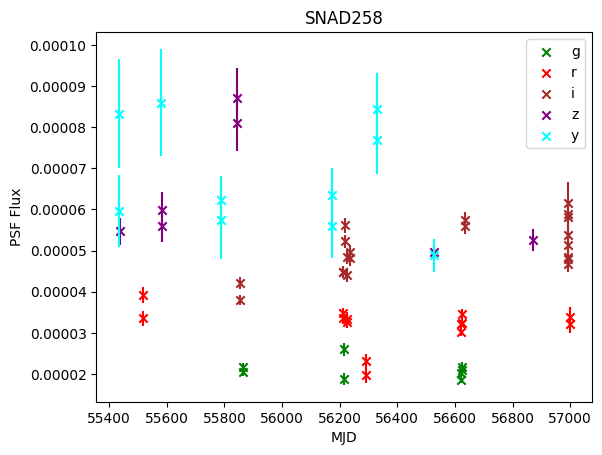

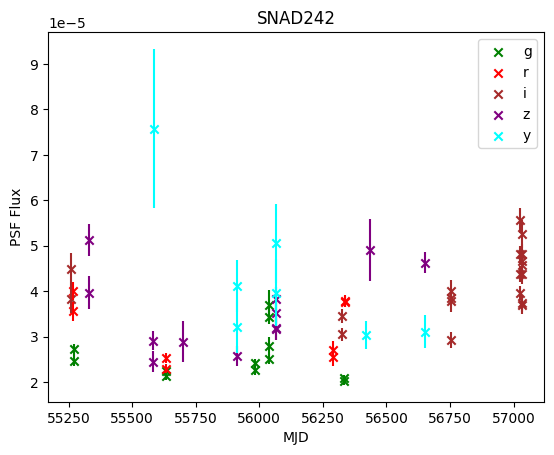

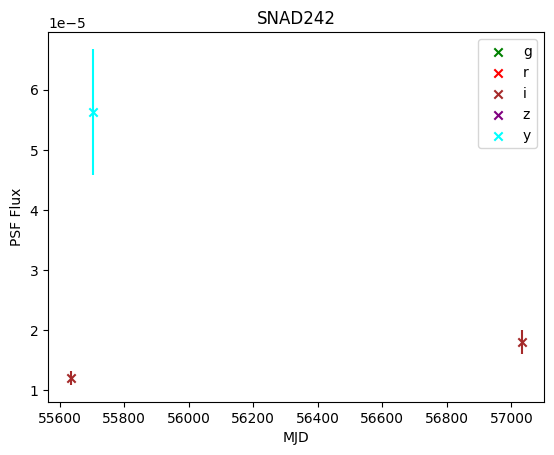

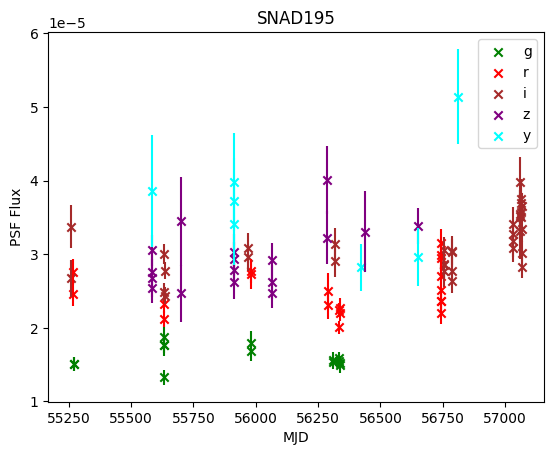

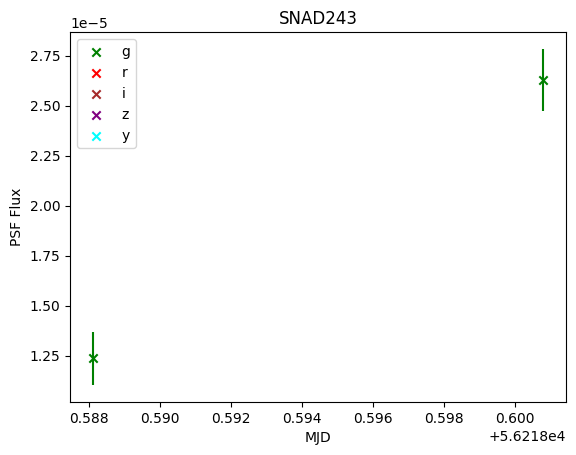

In [8]:
# Plot first five light curves

filter_id_to_name = dict(zip(range(1, 6), "grizy"))
get_name_from_filter_id = np.vectorize(filter_id_to_name.get)
filter_colors = {"g": "green", "r": "red", "i": "brown", "z": "purple", "y": "cyan"}

for snad_name, lc in ndf.iloc[:5][["Name", "lc"]].itertuples(index=False):
    # when we iterate a nested series we are getting pandas dataframes of light curves
    bands = get_name_from_filter_id(lc["filterID"])
    plt.figure()

    for band, color in filter_colors.items():
        band_idx = bands == band
        plt.scatter(
            lc["obsTime"][band_idx],
            lc["psfFlux"][band_idx],
            marker='x',
            color=color,
            label=band,
        )
        plt.errorbar(
            lc["obsTime"][band_idx],
            lc["psfFlux"][band_idx],
            lc["psfFluxErr"][band_idx],
            ls="",
            color=color,
        )
    
    plt.title(snad_name)
    plt.xlabel("MJD")
    plt.ylabel("PSF Flux")
    plt.legend()